In [1]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

# Pandas Imports
import pandas as pd

#Seaborn Imports
import seaborn as sns

#Computer Vision imports
import cv2

warnings.filterwarnings("ignore")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

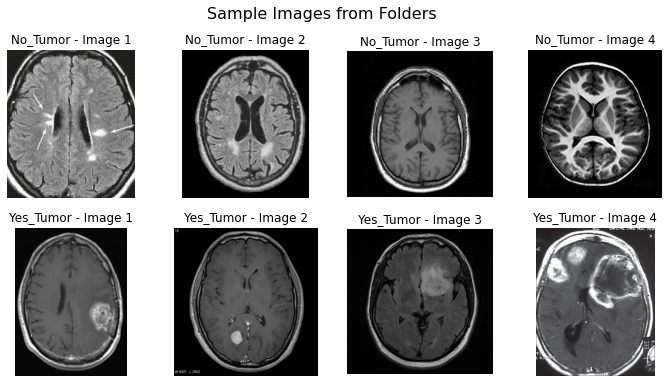

In [2]:
path = 'Training/'

classes = {'No_Tumor': 0, 'Yes_Tumor': 1}

# Create subplots for displaying images
fig, axs = plt.subplots(len(classes), 4, figsize=(12, 6))
fig.suptitle('Sample Images from Folders', fontsize=16)

for idx, (class_name, class_label) in enumerate(classes.items()):
    class_folder = os.path.join(path, class_name)
    image_files = os.listdir(class_folder)[:4]  # Get the first 4 image files from each folder

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(class_folder, image_file)
        image = cv2.imread(image_path)

        if image is not None:
            axs[idx, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs[idx, i].set_title(f'{class_name} - Image {i+1}')
            axs[idx, i].axis('off')
        else:
            print(f"Error loading image: {image_path}")

plt.show()

In [3]:
sample_train = []
labels_train = []

for class_name, class_label in classes.items():
    class_folder = os.path.join('Training', class_name)
    for image_file in os.listdir(class_folder):
        if image_file.startswith('.'):
            continue  # Skip hidden system files like '.DS_Store'
        
        image_path = os.path.join(class_folder, image_file)
        image = cv2.imread(image_path)

        if image is not None:
            # Resize the image to (2, 2)
            image = cv2.resize(image, (28, 28))
            sample_train.append(image)
            labels_train.append(class_label)
        else:
            print(f"Error loading image: {image_path}")
sample_train = np.array(sample_train)
labels_train = np.array(labels_train)

sample_train = sample_train[..., 0]  # Keep only the first channel (red)

In [4]:
sample_test = []
labels_test = []

for class_name, class_label in classes.items():
    class_folder = os.path.join('Testing', class_name)
    for image_file in os.listdir(class_folder):
        if image_file.startswith('.'):
            continue  # Skip hidden system files like '.DS_Store'
        
        image_path = os.path.join(class_folder, image_file)
        image = cv2.imread(image_path)

        if image is not None:
            # Resize the image to (2, 2)
            image = cv2.resize(image, (28, 28))
            sample_test.append(image)
            labels_test.append(class_label)
        else:
            print(f"Error loading image: {image_path}")
            
            
sample_test = np.array(sample_test)
labels_test = np.array(labels_test)


sample_test = sample_test[..., 0]  # Keep only the first channel (red)


In [5]:
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

In [6]:
print("Image data shape:", sample_train.shape)

Image data shape: (196, 28, 28)


In [7]:
num_samples, num_rows, num_cols = sample_train.shape
sample_train = sample_train.reshape(num_samples, -1)
sample_val = sample_val.reshape(sample_val.shape[0], -1)
sample_test = sample_test.reshape(sample_test.shape[0], -1)

In [8]:
# Standardize
ss = StandardScaler()
sample_train = ss.fit_transform(sample_train)
sample_val = ss.transform(sample_val)
sample_test = ss.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
mms = MinMaxScaler((-1, 1))
sample_train = mms.fit_transform(sample_train)
sample_val = mms.transform(sample_val)
sample_test = mms.transform(sample_test)

In [9]:
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

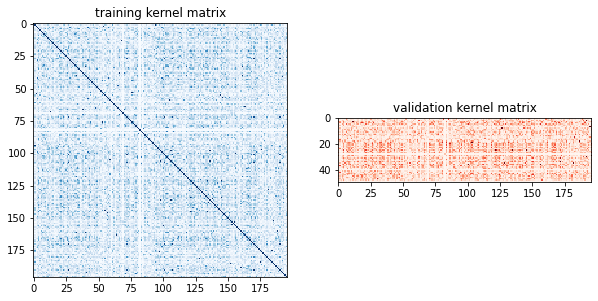

In [10]:
matrix_train = pauli_kernel.evaluate(x_vec=sample_train)
matrix_val = pauli_kernel.evaluate(x_vec=sample_val, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_val),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

In [11]:
pauli_svc = SVC(kernel='precomputed')
pauli_svc.fit(matrix_train, labels_train)
pauli_score = pauli_svc.score(matrix_val, labels_val)

print(f'Precomputed kernel classification test score: {pauli_score*100}%')

Precomputed kernel classification test score: 76.0%


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you've already trained the model as in your provided code snippet

# Calculate predictions
predictions = pauli_svc.predict(matrix_val)

# Calculate F1 score
f1 = f1_score(labels_val, predictions)

# Calculate precision
precision = precision_score(labels_val, predictions)

# Calculate recall
recall = recall_score(labels_val, predictions)

# Print scores
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

F1 Score: 0.8333333333333334
Precision: 0.7317073170731707
Recall: 0.967741935483871
